# GSM-ED: Elasto-damage

In [1]:
%matplotlib widget
import matplotlib.pylab as plt
import sympy as sp
import numpy as np
from IPython.display import display, Math, Markdown
from bmcs_matmod.api import GSMModel, GSM1D_ED
gsm_model = GSMModel(GSM1D_ED)
display(Markdown(gsm_model.gsm_def.latex_potentials()))

## class GSM1D_ED
### Helmholtz free energy
$$F = - \frac{E \varepsilon^{2} \left(\omega - 1\right)}{2} + \frac{z^{2}}{2}$$
$$\left\{ Y : \frac{E \varepsilon^{2}}{2}, \  Z : z\right\}$$
#### Mechanical dissipation
$$\gamma_{\mathrm{mech}} = Y \dot{\omega} - Z \dot{z}$$
#### Lagrangian
$$\mathcal{L} = - Y \dot{\omega} + Z \dot{z} - \lambda_{\mathrm{\phi}} \left(- \frac{S \left(\frac{Y}{S}\right)^{r + 1} \left(1 - \omega\right)^{c}}{r + 1} + Z + \varepsilon_{0} - \left|{\varepsilon}\right|\right)$$
#### Residuum
$$\frac{\partial \mathcal{L}}{\partial \mathcal{S}} = \left[\begin{matrix}\frac{S \lambda_{\mathrm{\phi}} \left(\frac{Y}{S}\right)^{r + 1} \left(1 - \omega\right)^{c}}{Y} - \dot{\omega}\\\dot{z} - \lambda_{\mathrm{\phi}}\\- Z - \varepsilon_{0} + \left|{\varepsilon}\right|\end{matrix}\right] = 0$$
### Legendre transform
#### Strain substitutions in dissipative terms
$$\left\{ \varepsilon : - \frac{\sigma}{E \left(\omega - 1\right)}\right\}$$
$$\left\{ \dot{\varepsilon} : \frac{\sigma \dot{\omega} - \dot{\sigma} \left(\omega - 1\right)}{E \left(\omega - 1\right)^{2}}\right\}$$
### Gibbs free energy
$$G = \sigma \varepsilon- \left[- \frac{E \varepsilon^{2} \left(\omega - 1\right)}{2} + \frac{z^{2}}{2}\right] $$
#### Gibbs free energy after strain substitutions
$$G = \frac{- E z^{2} \left(\omega - 1\right) - \sigma^{2}}{2 E \left(\omega - 1\right)}$$
$$\left\{ Y : \frac{\sigma^{2}}{2 E \left(\omega - 1\right)^{2}}, \  Z : z\right\}$$
#### Mechanical dissipation
$$\gamma_{\mathrm{mech}} = Y \dot{\omega} - Z \dot{z}$$
#### Lagrangian
$$\mathcal{L} = - Y \dot{\omega} + Z \dot{z} - \lambda_{\mathrm{\phi}} \left(- \frac{Y \left(\frac{Y}{S}\right)^{r} \left(1 - \omega\right)^{c}}{r + 1} + Z + \varepsilon_{0} - \frac{\left|{\frac{\sigma}{\omega - 1}}\right|}{E}\right)$$
#### Residuum
$$\frac{\partial \mathcal{L}}{\partial \mathcal{S}} = \left[\begin{matrix}- \dot{\omega} - \lambda_{\mathrm{\phi}} \left(- \frac{r \left(\frac{Y}{S}\right)^{r} \left(1 - \omega\right)^{c}}{r + 1} - \frac{\left(\frac{Y}{S}\right)^{r} \left(1 - \omega\right)^{c}}{r + 1}\right)\\\dot{z} - \lambda_{\mathrm{\phi}}\\- Z - \varepsilon_{0} + \frac{\left|{\frac{\sigma}{\omega - 1}}\right|}{E}\end{matrix}\right] = 0$$

## Linearly ascending loading

In [2]:
E_val = 30e+3  # Young's modulus in MPa
K_val = 1e+3  # Bulk modulus in MPa
f_c_val = 15 # Strength in MPa
eta_vp_val = 10e+4  # Viscosity in MPa s
eta_ve_val = 10e+4  # Viscosity in MPa s

# mparams = {gsm.E:10, gsm.c:1, gsm.r:1, gsm.S:10, gsm.eps_0:1}

mparams = dict(E=E_val, K=K_val, f_c=f_c_val, S=0.0001, r=1, c=1,
            eps_0=0.001, eta_ve=eta_ve_val, eta_vp=eta_vp_val)
gsm_model.set_params(**mparams)
f_time = 10  # Final time in seconds
n_t = 151
t_t = np.linspace(0, f_time, n_t)
eps_max = 0.0025
eps_n_t = np.linspace(0, eps_max, n_t)

response_F = gsm_model.get_F_response(eps_n_t, t_t)
t_t_ec = response_F.t_t
eps_t_ec = response_F.eps_t[:, 0]
sig_t_ec = response_F.sig_t[:, 0, 0]
# use the stress history to reproduce the response using stress control

In [4]:
response_G = gsm_model.get_G_response(sig_t_ec, t_t)
iter_t = response_G.iter_t[:, 0]
t_t_sc = response_G.t_t
eps_t_sc = response_G.eps_t[:, 0, 0]
sig_t_sc = response_G.sig_t[:, 0]
eps_t_ec.shape, sig_t_ec.shape, eps_t_sc.shape, sig_t_sc.shape

In [5]:
omega_t_ec = response_F.Eps_t.omega_a[:, 0, :]
z_t_ec = response_F.Eps_t.z_a[:, 0, :]
omega_t_sc = response_G.Eps_t.omega_a[:, 0, :]
z_t_sc = response_G.Eps_t.z_a[:, 0, :]
(omega_t_ec.shape, z_t_ec.shape, omega_t_sc.shape, z_t_sc.shape)

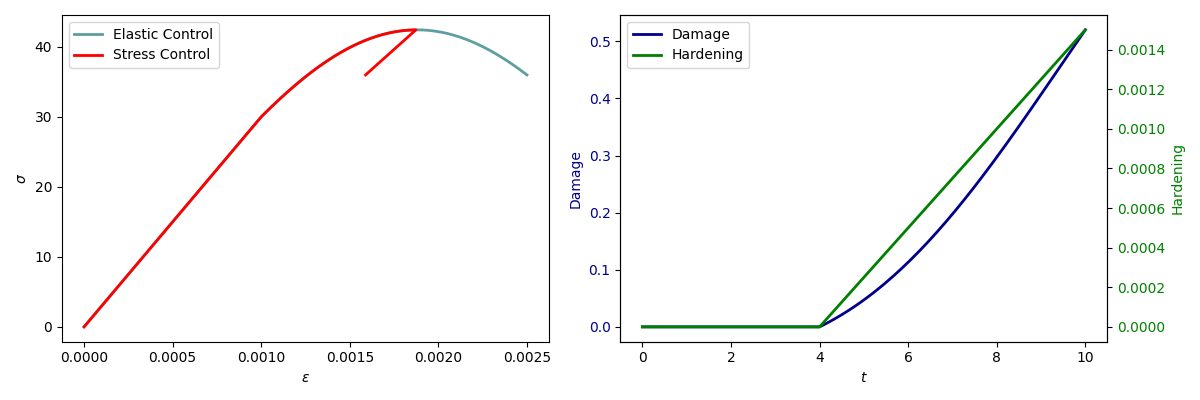

In [6]:
fig, (ax_sig, ax_eps) = plt.subplots(1, 2, figsize=(12, 4))

# Left: Stress–strain curves (elastic control and stress control)
ax_sig.plot(eps_t_ec, sig_t_ec, color='cadetblue', lw=2, label='Elastic Control')
ax_sig.plot(eps_t_sc, sig_t_sc, color='red', lw=2, label='Stress Control')
ax_sig.set_xlabel(r'$\varepsilon$')
ax_sig.set_ylabel(r'$\sigma$')
ax_sig.legend()

# Right: Damage and hardening profiles
ax_eps.plot(t_t_ec, omega_t_ec, color='darkblue', lw=2, label='Damage')
ax_eps.set_xlabel(r'$t$')
ax_eps.set_ylabel('Damage', color='darkblue')
ax_eps.tick_params(axis='y', labelcolor='darkblue')

# Twin axis for hardening (z)
ax_hard = ax_eps.twinx()
ax_hard.plot(t_t_ec, z_t_ec, color='green', lw=2, label='Hardening')
ax_hard.set_ylabel('Hardening', color='green')
ax_hard.tick_params(axis='y', labelcolor='green')

# Combine legends from both axes
lines1, labels1 = ax_eps.get_legend_handles_labels()
lines2, labels2 = ax_hard.get_legend_handles_labels()
ax_eps.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.tight_layout()
plt.show()
